In [1]:
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2024-06-26 23:33:38.205205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 23:33:38.205305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 23:33:38.384182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/data-padi/data_padi/train'
classes = ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast',
           'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa',
           'sheath_blight', 'tungro']

images = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(base_dir, class_name)
    
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image)
            labels.append(class_idx)

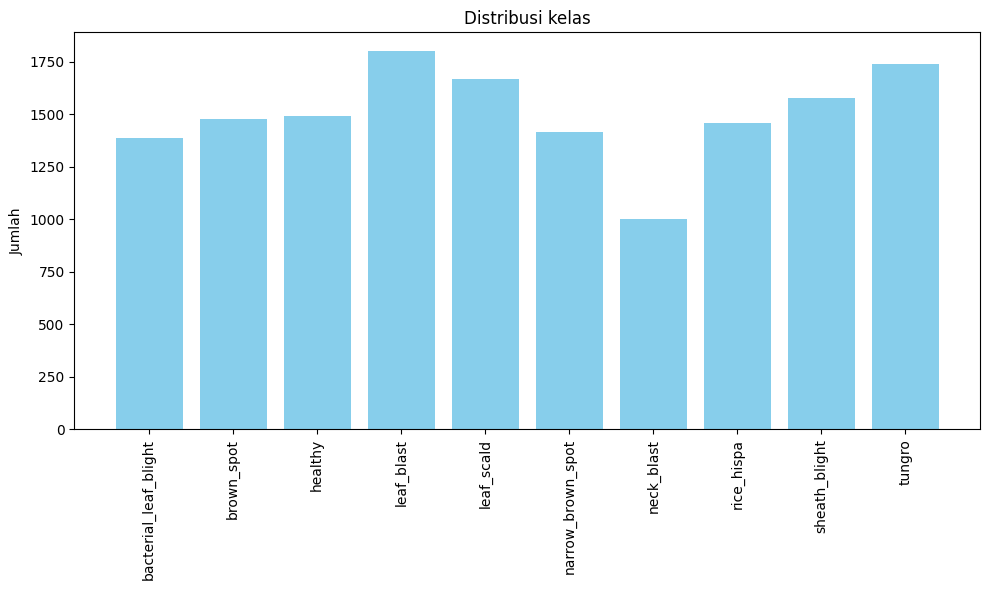

In [3]:
class_indices = np.array(labels)
class_counts = np.bincount(class_indices)

plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.ylabel('Jumlah')
plt.title('Distribusi kelas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

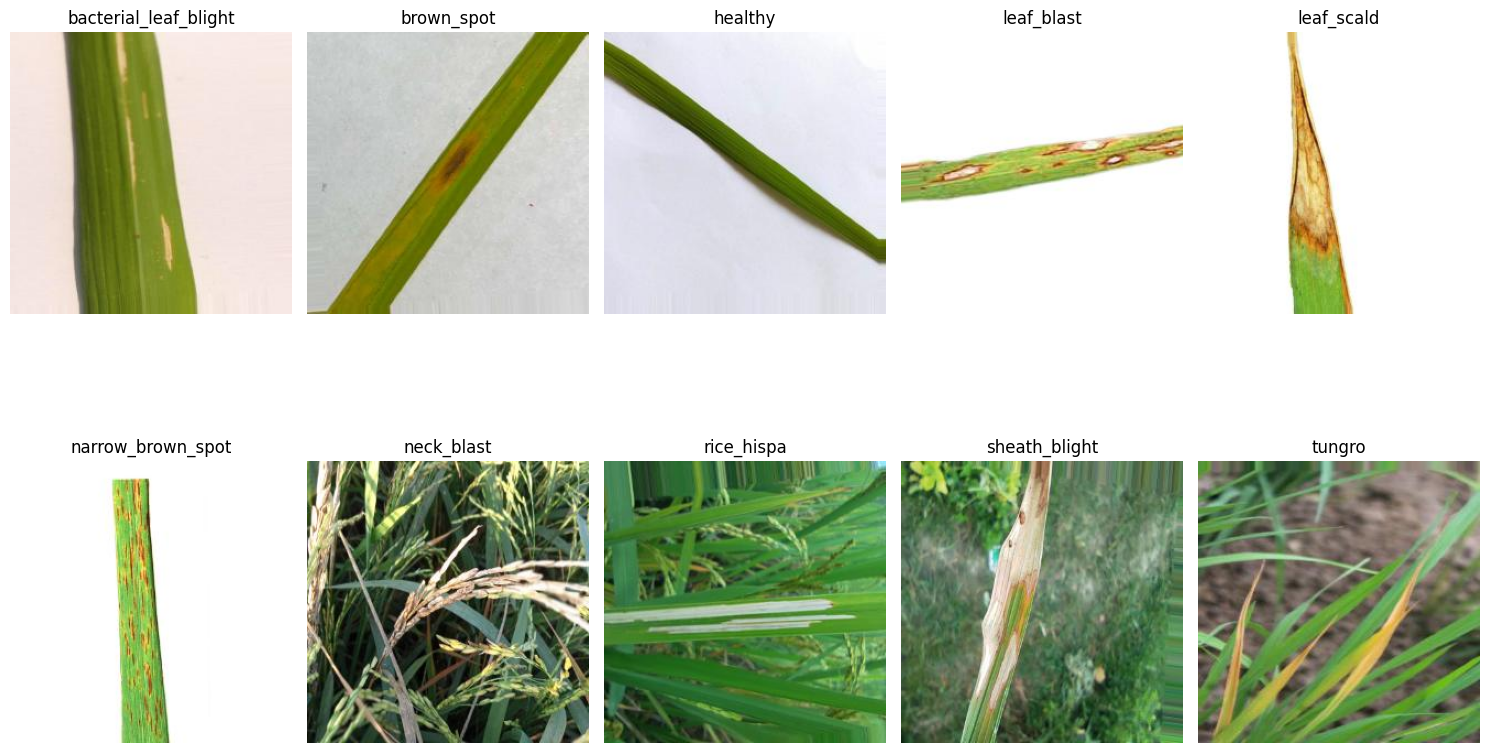

In [4]:
image_paths = {
    'bacterial_leaf_blight': '/kaggle/input/data-padi/data_padi/train/bacterial_leaf_blight/bacterial_leaf_blight1005.jpg',
    'brown_spot': '/kaggle/input/data-padi/data_padi/train/brown_spot/brown_spot1.jpg',
    'healthy': '/kaggle/input/data-padi/data_padi/train/healthy/healthy100.jpg',
    'leaf_blast': '/kaggle/input/data-padi/data_padi/train/leaf_blast/leaf_blast1001.jpg',
    'leaf_scald': '/kaggle/input/data-padi/data_padi/train/leaf_scald/leaf_scald1.jpg',
    'narrow_brown_spot': '/kaggle/input/data-padi/data_padi/train/narrow_brown_spot/narrow_brown_spot1001.jpg',
    'neck_blast': '/kaggle/input/data-padi/data_padi/train/neck_blast/neck_blast0.jpg',
    'rice_hispa': '/kaggle/input/data-padi/data_padi/train/rice_hispa/rice_hispa1058.jpg',
    'sheath_blight': '/kaggle/input/data-padi/data_padi/train/sheath_blight/sheath_blight10.jpg',
    'tungro': '/kaggle/input/data-padi/data_padi/train/tungro/tungro1012.jpg'
}

# Visualisasi tiap kelas
plt.figure(figsize=(15, 10))
for i, (class_name, image_path) in enumerate(image_paths.items(), 1):
    image = cv2.imread(image_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
base_dir = '/kaggle/input/data-padi/data_padi'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

target_size = (256, 256)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 13523 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 3422 images belonging to 10 classes.


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
    )

history = model.fit(
    train_generator, 
    epochs=20, 
    batch_size=32, 
    validation_data=valid_generator,
)

Epoch 1/20
  2/423 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.0547 - loss: 2.3123   

I0000 00:00:1719444906.351593    6780 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719444906.373837    6780 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


342/423 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.2298 - loss: 2.0194

W0000 00:00:1719444941.879669    6779 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


422/423 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2578 - loss: 1.9533

W0000 00:00:1719444947.751838    6779 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


423/423 ━━━━━━━━━━━━━━━━━━━━ 61s 111ms/step - accuracy: 0.2584 - loss: 1.9517 - val_accuracy: 0.6067 - val_loss: 1.0922
Epoch 2/20


W0000 00:00:1719444953.170704    6780 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


423/423 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6377 - loss: 1.0103 - val_accuracy: 0.7573 - val_loss: 0.6778
Epoch 3/20
423/423 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.7590 - loss: 0.6784 - val_accuracy: 0.8200 - val_loss: 0.5330
Epoch 4/20
423/423 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.8108 - loss: 0.5261 - val_accuracy: 0.8107 - val_loss: 0.5869
Epoch 5/20
423/423 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.8522 - loss: 0.4226 - val_accuracy: 0.8627 - val_loss: 0.3808
Epoch 6/20
423/423 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8842 - loss: 0.3308 - val_accuracy: 0.7960 - val_loss: 0.5798
Epoch 7/20
423/423 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.8936 - loss: 0.2949 - val_accuracy: 0.8793 - val_loss: 0.3383
Epoch 8/20
423/423 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.9254 - loss: 0.2052 - val_accuracy: 0.8960 - val_loss: 0.2737
Epoch 9/20
423/423 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9325 - loss: 0.1923 - val_accurac

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,668,928 (33.07 MB)

 Trainable params: 2,889,642 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,779,286 (22.05 MB)

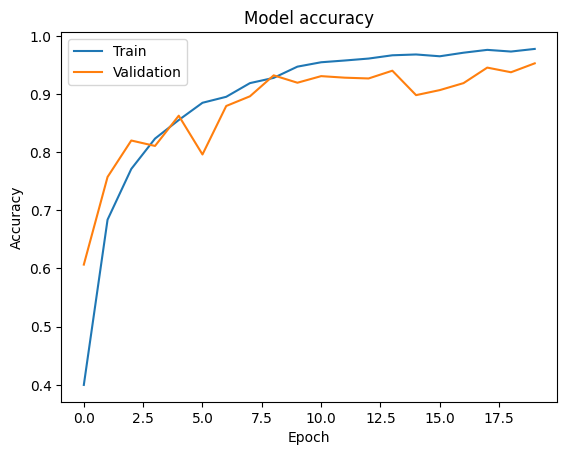

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

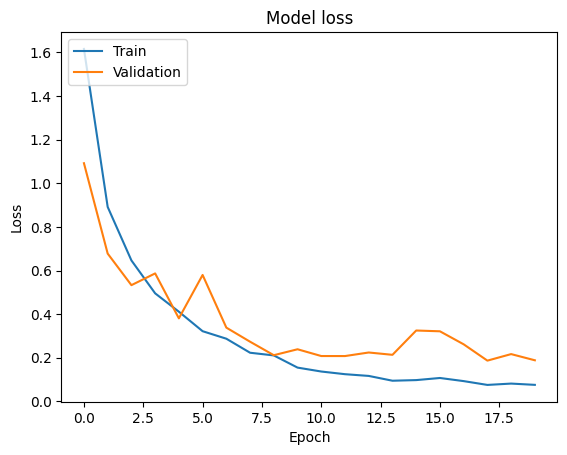

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

In [26]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.9054 - loss: 0.6815
Test accuracy: 0.9035651683807373


In [33]:
from tensorflow.keras.preprocessing.image import load_img
image_path = '/kaggle/input/data-padi/data_padi/test/bacterial_leaf_blight/BACTERIALBLIGHT2_079.jpg'
img = load_img(image_path, target_size=(256, 256))
img_array = np.array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [34]:
predicted_class = np.argmax(prediction, axis=1)
predicted_class

array([0])

In [35]:
model.save('model_cnn.h5')